In [24]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [26]:
# load top_words.txt and get the lemma for them in a map
# top words from: https://www.ef.edu/english-resources/english-vocabulary/top-3000-words/
all_clues = []
with open('top_words.txt', 'r') as f:
    for line in f:
        token = line.strip()
        lemma = nlp(token)
        if lemma.has_vector:
            all_clues.append(lemma)

In [27]:

print("Enter two space-separated words")
words = 'cat dog'

tokens = nlp(words)

for token in tokens:
    # Printing the following attributes of each token.
    # text: the word string, has_vector: if it contains
    # a vector representation in the model, 
    # vector_norm: the algebraic norm of the vector,
    # is_oov: if the word is out of vocabulary.
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

token1, token2 = tokens[0], tokens[1]

print("Similarity:", token1.similarity(token2))

Enter two space-separated words
cat True 63.188496 False
dog True 75.254234 False
Similarity: 0.8220816850662231


In [ ]:
# 1) cluster the words based on their similarity
# 2) find the centroid of each cluster
# 3) find the closest word to the centroid, and use it as the clue
# 4) we may need to project the words onto a sphere? or do something different
#    because they don't satisfy the triangle inequality

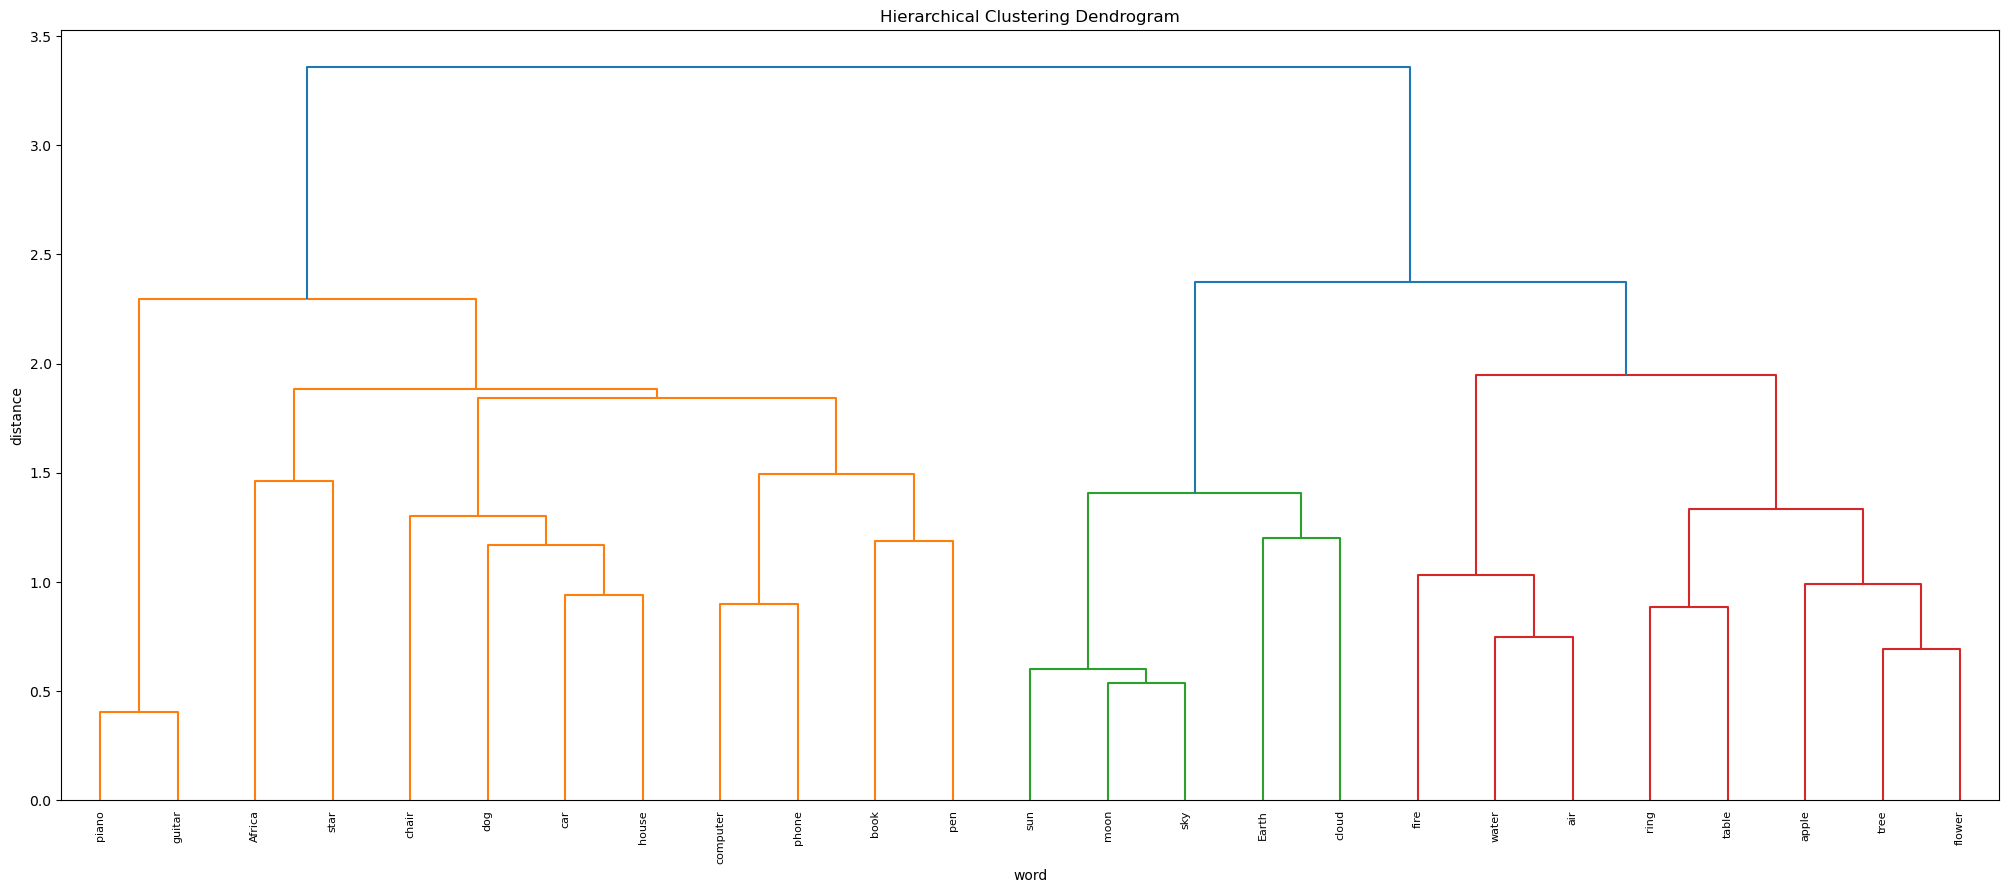

[[ 4.         12.          0.40340318  2.        ]
 [21.         23.          0.53420642  2.        ]
 [20.         26.          0.6012987   3.        ]
 [15.         16.          0.69341501  2.        ]
 [17.         18.          0.74537161  2.        ]
 [ 1.          7.          0.88413298  2.        ]
 [10.         11.          0.900645    2.        ]
 [13.         14.          0.94130224  2.        ]
 [ 5.         28.          0.99012435  3.        ]
 [19.         29.          1.03051718  3.        ]
 [ 2.         32.          1.16658829  3.        ]
 [ 8.          9.          1.18807974  2.        ]
 [ 3.         24.          1.19896672  2.        ]
 [ 6.         35.          1.30375822  4.        ]
 [30.         33.          1.3334343   5.        ]
 [27.         37.          1.40617553  5.        ]
 [ 0.         22.          1.46144646  2.        ]
 [31.         36.          1.49177979  4.        ]
 [38.         42.          1.84200604  8.        ]
 [41.         43.          1.88

In [50]:
# make a list of 25 words
words = ['Africa', 'ring', 'dog', 'Earth', 'piano', 
         'apple', 'chair', 'table', 'book', 'pen', 
         'computer', 'phone', 'guitar', 'car', 'house', 
         'tree', 'flower', 'water', 'air', 'fire', 
         'sun', 'moon', 'star', 'sky', 'cloud']
words = [nlp(word) for word in words]

# cluster the words into groups using scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import numpy as np
# use the wordA.similarity(wordB) metric
# to get a similarity matrix
similarity_matrix = np.zeros((len(words), len(words)))
for i in range(len(words)):
    for j in range(len(words)):
        similarity_matrix[i, j] = words[i].similarity(words[j])
condensed_similarity_matrix = pdist(similarity_matrix)
# use the similarity matrix to cluster the words
Z = linkage(condensed_similarity_matrix, 'ward')

# plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('word')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=[word.text for word in words]
)
plt.show()

print(Z)

In [56]:
class Node(object):
    def __init__(self, distance):
        self.distance = distance
        self.children = []
        self.parent = None
        self.siblings = []
        self.lemma = None

class Cluster(object):
    def __init__(self, lemmas, distance):
        self.lemmas = lemmas
        self.distance = distance
        self.centroid = np.mean([lemma.vector for lemma in lemmas])


# 1) create a proper tree structure,
#    where each node has the average distance of its children
#    (like shown in the dendrogram) how to do this? # TODO
def convert_to_tree(linkage, words):
    clusters = []
    for i, merge in enumerate(linkage):
        if merge[0] < len(words):
            # if it is an original point read it from the centers array
            a = words[int(merge[0]) - 1]
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]

        if merge[1] < len(words):
            b = words[int(merge[1]) - 1]
        else:
            b = clusters[int(merge[1])]
        # the clusters are 1-indexed by scipy
        clusters[1 + i + len(linkage)] = {
            'children' : [a, b]
        }
        # ^ you could optionally store other info here (e.g distances)
    return clusters


# print the cluster groups from the linkage Z
# from: https://stackoverflow.com/questions/9838861/scipy-linkage-format
def convert_linkage_to_tree(linkage, words):
    clusters = {}
    for i, merge in enumerate(linkage):
        if merge[0] < len(words):
            # if it is an original point read it from the centers array
            a = words[int(merge[0]) - 1]
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]

        if merge[1] < len(words):
            b = words[int(merge[1]) - 1]
        else:
            b = clusters[int(merge[1])]
        # the clusters are 1-indexed by scipy
        clusters[1 + i + len(linkage)] = {
            'children' : [a, b]
        }
        # ^ you could optionally store other info here (e.g distances)
    return clusters


clusters = convert_linkage_to_tree(Z, words)
clusters

{25: {'children': [Earth, phone]},
 26: {'children': [sun, star]},
 27: {'children': [fire, {'children': [sun, star]}]},
 28: {'children': [house, tree]},
 29: {'children': [flower, water]},
 30: {'children': [Africa, chair]},
 31: {'children': [pen, computer]},
 32: {'children': [guitar, car]},
 33: {'children': [piano, {'children': [house, tree]}]},
 34: {'children': [air, {'children': [flower, water]}]},
 35: {'children': [ring, {'children': [guitar, car]}]},
 36: {'children': [table, book]},
 37: {'children': [dog, sky]},
 38: {'children': [apple, {'children': [ring, {'children': [guitar, car]}]}]},
 39: {'children': [{'children': [Africa, chair]},
   {'children': [piano, {'children': [house, tree]}]}]},
 40: {'children': [{'children': [fire, {'children': [sun, star]}]},
   {'children': [dog, sky]}]},
 41: {'children': [cloud, moon]},
 42: {'children': [{'children': [pen, computer]},
   {'children': [table, book]}]},
 43: {'children': [{'children': [apple,
     {'children': [ring, 

In [ ]:
# 2) find clues for each group, and choose the top clue
#    (by cluster average distance and distance from clue to the center of the cluster) # TODO

